<a href="https://colab.research.google.com/github/inglebhavin98/colab/blob/main/dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("borg_traces_data.csv")


In [ ]:
df.head()


,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,...,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,0,0,2,94591244395,3,1,200,0,144,168846390496,...,0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7.0,FAIL,1.0
1,1,2517305308183,2,260697606809,2,0,360,221495397286,335,85515092,...,0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7.0,FAIL,1.0
2,2,195684022913,6,276227177776,2,0,103,0,376,169321752432,...,0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7.0,SCHEDULE,0.0
3,3,0,2,10507389885,3,0,200,0,1977,178294817221,...,0.041626,0.000225,1.359102,0.007643,1.0,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8.0,FAIL,1.0
4,4,1810627494172,3,25911621841,2,0,0,0,3907,231364893292,...,0.000272,0.000010,NaN,NaN,1.0,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2.0,FINISH,0.0


In [ ]:
def parse_dict(x):
    try:
        return ast.literal_eval(x)
    except:
        return {}

df['resource_request'] = df['resource_request'].apply(parse_dict)
df['average_usage'] = df['average_usage'].apply(parse_dict)

In [ ]:
df['req_cpu'] = df['resource_request'].apply(lambda x: x.get('cpus', 0))
df['req_mem'] = df['resource_request'].apply(lambda x: x.get('memory', 0))

df['cpu_usage'] = df['average_usage'].apply(lambda x: x.get('cpus', 0))
df['mem_usage'] = df['average_usage'].apply(lambda x: x.get('memory', 0))


In [ ]:
df['req_cpu'] = df['resource_request'].apply(lambda x: x.get('cpus', 0))
df['req_mem'] = df['resource_request'].apply(lambda x: x.get('memory', 0))

df['cpu_usage'] = df['average_usage'].apply(lambda x: x.get('cpus', 0))
df['mem_usage'] = df['average_usage'].apply(lambda x: x.get('memory', 0))


In [ ]:
df['duration'] = df['end_time'] - df['start_time']
df['log_duration'] = np.log(df['duration'] + 1)


In [ ]:
df_task = df.groupby(['collection_id', 'instance_index']).agg({
    'failed': 'max',                 # if failed at any point
    'priority': 'max',
    'req_cpu': 'max',
    'req_mem': 'max',
    'cpu_usage': 'mean',
    'mem_usage': 'mean',
    'duration': 'sum',
    'assigned_memory': 'mean' # Include assigned_memory in the aggregation
}).reset_index()

In [ ]:
df_task['log_duration'] = np.log(df_task['duration'] + 1)

In [ ]:
df_task['mem_overprov'] = df_task['req_mem'] / (df_task['mem_usage'] + 1e-6)
df_task['cpu_overprov'] = df_task['req_cpu'] / (df_task['cpu_usage'] + 1e-6)

In [ ]:
df_task = df_task.replace([np.inf, -np.inf], np.nan)
df_task = df_task.dropna()

In [ ]:
df_task = df_task[df_task['mem_overprov'] < 100]
df_task = df_task[df_task['cpu_overprov'] < 100]
df_task = df_task[df_task['duration'] > 0]

In [ ]:
df_task[['mem_overprov', 'cpu_overprov', 'duration']].describe()

,mem_overprov,cpu_overprov,duration
count,2001.000000,2001.000000,2.001000e+03
mean,3.519045,10.293706,2.697926e+08
std,6.786260,15.824913,1.607422e+08
min,0.000000,0.000000,2.000000e+06
25%,1.109974,1.127232,3.000000e+08
50%,1.730241,2.601266,3.000000e+08
75%,3.314951,12.372039,3.000000e+08
max,74.399460,97.848178,3.300000e+09


In [ ]:
df_task['failed'].mean()

np.float64(0.25237381309345325)

In [ ]:
X = df_task[['mem_overprov', 'cpu_overprov', 'priority']]
X = sm.add_constant(X)

y = df_task['failed']

model_fail = sm.Logit(y, X).fit()
print(model_fail.summary())

Optimization terminated successfully.
         Current function value: 0.562350
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 failed   No. Observations:                 2001
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            3
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                0.004564
Time:                        14:20:55   Log-Likelihood:                -1125.3
converged:                       True   LL-Null:                       -1130.4
Covariance Type:            nonrobust   LLR p-value:                   0.01604
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3295      0.105    -12.647      0.000      -1.536      -1.123
mem_overprov    -0.0058

In [ ]:
X = df_task[['mem_overprov', 'cpu_overprov', 'priority']]
X = sm.add_constant(X)

y = df_task['log_duration']

model_time = sm.OLS(y, X).fit()
print(model_time.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     89.05
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           4.44e-54
Time:                        14:23:48   Log-Likelihood:                -3110.8
No. Observations:                2001   AIC:                             6230.
Df Residuals:                    1997   BIC:                             6252.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           19.1450      0.051    374.721   

In [ ]:
# LOG TRANSFORMAITON
import numpy as np

df_task['log_mem_overprov'] = np.log(df_task['mem_overprov'] + 1)

In [ ]:
df_task['log_req_mem'] = np.log(df_task['req_mem'] + 1)

In [ ]:
df_task['mem_priority_interaction'] = df_task['log_mem_overprov'] * df_task['priority']

In [ ]:
df_task = df_task.replace([np.inf, -np.inf], np.nan)
df_task = df_task.dropna()

In [ ]:
import statsmodels.api as sm

X = df_task[['log_mem_overprov', 'cpu_overprov', 'priority']]
X = sm.add_constant(X)

y = df_task['failed']

model1_fail = sm.Logit(y, X).fit(maxiter=100)
print(model1_fail.summary())

Optimization terminated successfully.
         Current function value: 0.562025
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 failed   No. Observations:                 2001
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            3
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                0.005139
Time:                        14:37:17   Log-Likelihood:                -1124.6
converged:                       True   LL-Null:                       -1130.4
Covariance Type:            nonrobust   LLR p-value:                  0.008815
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1903      0.157     -7.596      0.000      -1.497      -0.883
log_mem_ove

In [ ]:
X = df_task[['log_mem_overprov', 'cpu_overprov', 'priority']]
X = sm.add_constant(X)

y = df_task['log_duration']

model1_time = sm.OLS(y, X).fit()
print(model1_time.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     81.92
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           5.56e-50
Time:                        14:37:30   Log-Likelihood:                -3120.3
No. Observations:                2001   AIC:                             6249.
Df Residuals:                    1997   BIC:                             6271.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               19.6701      0.076  

In [ ]:
X = df_task[['log_req_mem', 'cpu_overprov', 'priority']]
X = sm.add_constant(X)

y = df_task['failed']

model2_fail = sm.Logit(y, X).fit(maxiter=100)
print(model2_fail.summary())

Optimization terminated successfully.
         Current function value: 0.560974
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 failed   No. Observations:                 2001
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            3
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                0.006999
Time:                        14:37:40   Log-Likelihood:                -1122.5
converged:                       True   LL-Null:                       -1130.4
Covariance Type:            nonrobust   LLR p-value:                  0.001232
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.2675      0.106    -11.988      0.000      -1.475      -1.060
log_req_mem     -8.3287

In [ ]:
X = df_task[['log_req_mem', 'cpu_overprov', 'priority']]
X = sm.add_constant(X)

y = df_task['log_duration']

model2_time = sm.OLS(y, X).fit()
print(model2_time.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     35.99
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           1.19e-22
Time:                        14:37:48   Log-Likelihood:                -3183.7
No. Observations:                2001   AIC:                             6375.
Df Residuals:                    1997   BIC:                             6398.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.8920      0.053    354.840   

In [ ]:
X = df_task[['log_mem_overprov', 'priority', 'mem_priority_interaction', 'cpu_overprov']]
X = sm.add_constant(X)

y = df_task['failed']

model3_fail = sm.Logit(y, X).fit(maxiter=100)
print(model3_fail.summary())

Optimization terminated successfully.
         Current function value: 0.560587
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 failed   No. Observations:                 2001
Model:                          Logit   Df Residuals:                     1996
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                0.007685
Time:                        14:38:16   Log-Likelihood:                -1121.7
converged:                       True   LL-Null:                       -1130.4
Covariance Type:            nonrobust   LLR p-value:                  0.001634
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.8954      0.200     -4.468      0.000      -1.288

In [ ]:
X = df_task[['log_mem_overprov', 'priority', 'mem_priority_interaction', 'cpu_overprov']]
X = sm.add_constant(X)

y = df_task['log_duration']

model3_time = sm.OLS(y, X).fit()
print(model3_time.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     76.77
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           1.27e-60
Time:                        14:38:33   Log-Likelihood:                -3093.3
No. Observations:                2001   AIC:                             6197.
Df Residuals:                    1996   BIC:                             6225.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
### graphs for rq2


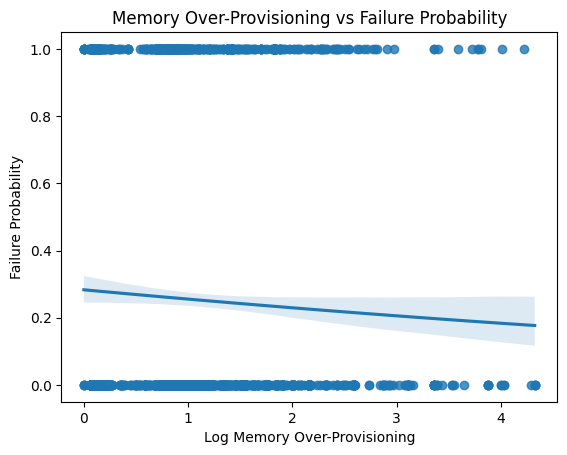

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x='log_mem_overprov', y='failed', data=df_task, logistic=True)
plt.title("Memory Over-Provisioning vs Failure Probability")
plt.xlabel("Log Memory Over-Provisioning")
plt.ylabel("Failure Probability")
plt.show()

In [ ]:
## 🔵 GRAPH 2 — Memory Over-Provisioning vs Duration

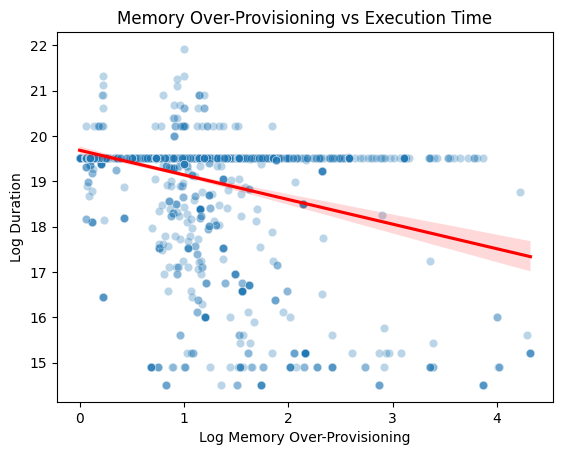

In [ ]:
sns.scatterplot(x='log_mem_overprov', y='log_duration', data=df_task, alpha=0.3)
sns.regplot(x='log_mem_overprov', y='log_duration', data=df_task, scatter=False, color='red')
plt.title("Memory Over-Provisioning vs Execution Time")
plt.xlabel("Log Memory Over-Provisioning")
plt.ylabel("Log Duration")
plt.show()

In [ ]:
## 🟡 GRAPH 3 — Failure Rate by Memory Bins (VERY IMPORTANT)

/tmp/ipython-input-2260752377.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_by_bin = df_task.groupby('mem_bin')['failed'].mean()


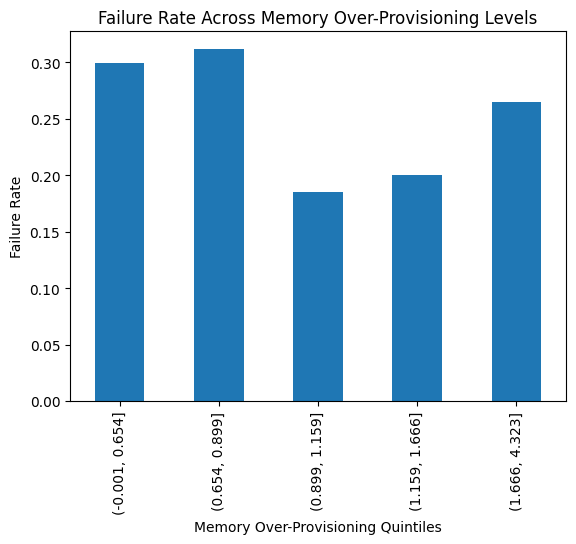

In [ ]:
df_task['mem_bin'] = pd.qcut(df_task['log_mem_overprov'], 5)

failure_by_bin = df_task.groupby('mem_bin')['failed'].mean()

failure_by_bin.plot(kind='bar')
plt.title("Failure Rate Across Memory Over-Provisioning Levels")
plt.ylabel("Failure Rate")
plt.xlabel("Memory Over-Provisioning Quintiles")
plt.show()

In [ ]:
## 🟢 GRAPH 4 — Duration by Memory Bins

/tmp/ipython-input-2188813345.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_by_bin = df_task.groupby('mem_bin')['log_duration'].mean()


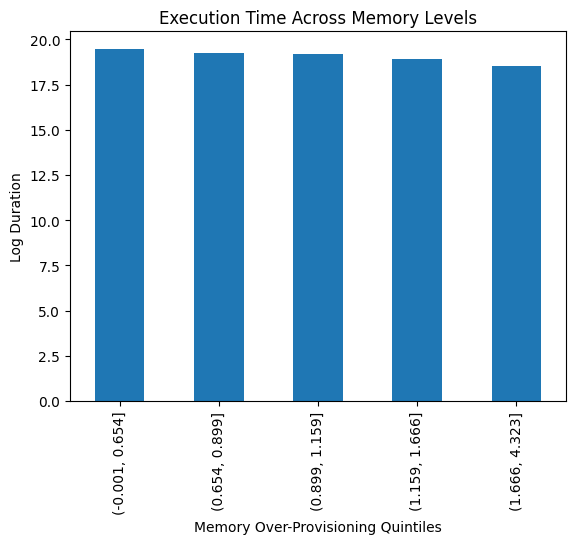

In [ ]:
duration_by_bin = df_task.groupby('mem_bin')['log_duration'].mean()

duration_by_bin.plot(kind='bar')
plt.title("Execution Time Across Memory Levels")
plt.ylabel("Log Duration")
plt.xlabel("Memory Over-Provisioning Quintiles")
plt.show()

In [ ]:
##🟣 GRAPH 5 — Requested Memory vs Failure (IMPORTANT)

/tmp/ipython-input-3269402100.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_task.groupby('req_mem_bin')['failed'].mean().plot(kind='bar')


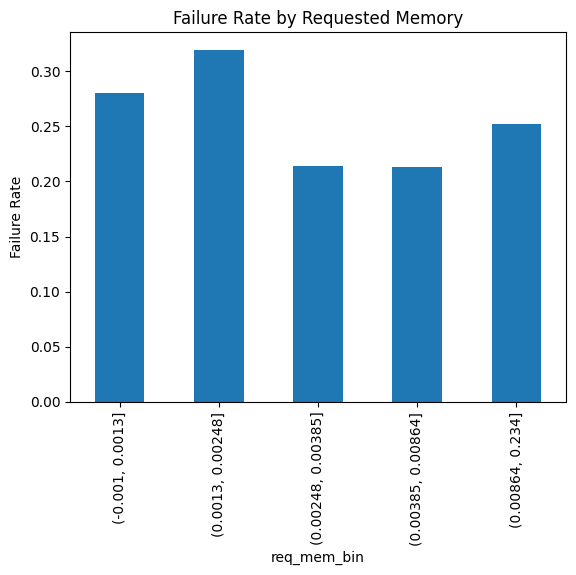

In [ ]:
df_task['req_mem_bin'] = pd.qcut(df_task['log_req_mem'], 5)

df_task.groupby('req_mem_bin')['failed'].mean().plot(kind='bar')
plt.title("Failure Rate by Requested Memory")
plt.ylabel("Failure Rate")
plt.show()

In [ ]:
## 🟠 GRAPH 6 — Interaction Effect (ADVANCED, HIGH VALUE)

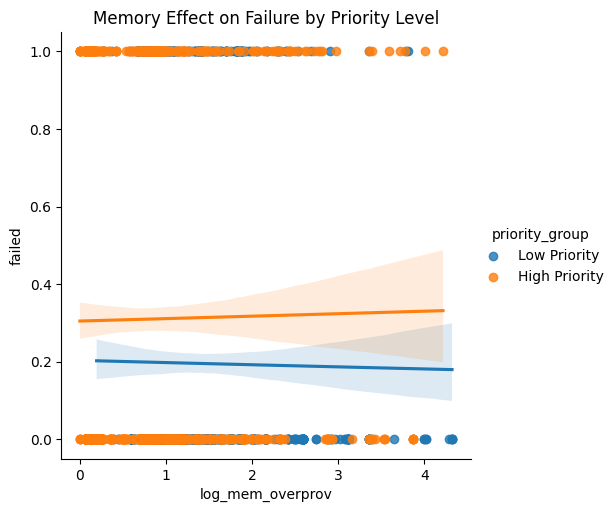

In [ ]:
df_task['priority_group'] = pd.qcut(df_task['priority'], 2, labels=['Low Priority', 'High Priority'])

sns.lmplot(
    x='log_mem_overprov',
    y='failed',
    hue='priority_group',
    data=df_task,
    logistic=True
)
plt.title("Memory Effect on Failure by Priority Level")
plt.show()

In [ ]:
### Table 1 — Summary Statistics

In [ ]:
df_task[['failed', 'log_mem_overprov', 'log_req_mem', 'log_duration']].describe()

,failed,log_mem_overprov,log_req_mem,log_duration
count,2001.000000,2001.000000,2001.000000,2001.000000
mean,0.252374,1.133268,0.008040,19.067792
std,0.434483,0.737402,0.018103,1.219837
min,0.000000,0.000000,0.000000,14.508658
25%,0.000000,0.746676,0.001302,19.519293
50%,0.000000,1.004390,0.003412,19.519293
75%,1.000000,1.462086,0.006487,19.519293
max,1.000000,4.322800,0.233635,21.917188


In [ ]:
######RQ3
import numpy as np

df_task['log_req_mem'] = np.log(df_task['req_mem'] + 1)
df_task['log_req_cpu'] = np.log(df_task['req_cpu'] + 1)

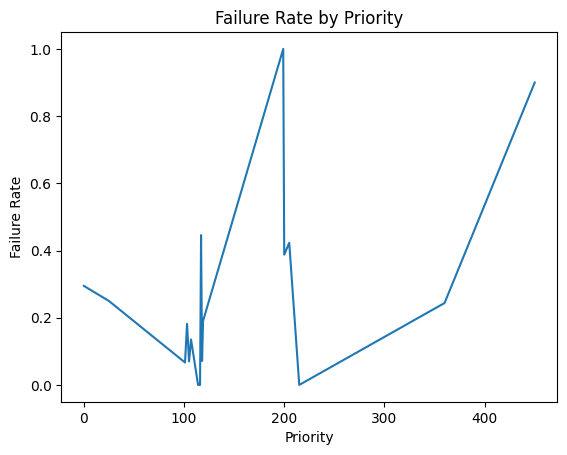

In [ ]:
df_task.groupby('priority')['failed'].mean().plot(kind='line')
plt.title("Failure Rate by Priority")
plt.xlabel("Priority")
plt.ylabel("Failure Rate")
plt.show()

/tmp/ipython-input-990177241.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_task.groupby('priority_bin')['failed'].mean().plot(kind='bar')


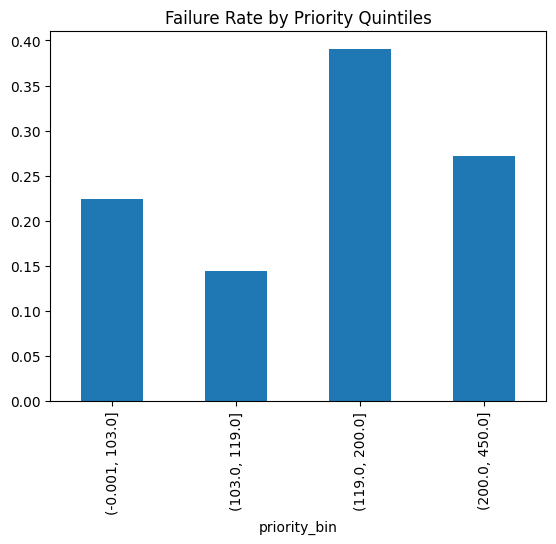

In [ ]:
df_task['priority_bin'] = pd.qcut(df_task['priority'], 5, duplicates='drop')

df_task.groupby('priority_bin')['failed'].mean().plot(kind='bar')
plt.title("Failure Rate by Priority Quintiles")
plt.show()

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df_task[['priority']])
y = df_task['failed']

model1 = sm.Logit(y, X).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.563073
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 failed   No. Observations:                 2001
Model:                          Logit   Df Residuals:                     1999
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                0.003283
Time:                        15:05:42   Log-Likelihood:                -1126.7
converged:                       True   LL-Null:                       -1130.4
Covariance Type:            nonrobust   LLR p-value:                  0.006438
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2774      0.088    -14.478      0.000      -1.450      -1.104
priority       0.0012      0.

In [ ]:
X = sm.add_constant(df_task[['priority', 'log_req_mem', 'log_req_cpu', 'log_duration']])
y = df_task['failed']

model2 = sm.Logit(y, X).fit(maxiter=100)
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.554294
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 failed   No. Observations:                 2001
Model:                          Logit   Df Residuals:                     1996
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                 0.01882
Time:                        15:06:00   Log-Likelihood:                -1109.1
converged:                       True   LL-Null:                       -1130.4
Covariance Type:            nonrobust   LLR p-value:                 1.278e-08
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -6.0841      1.056     -5.761      0.000      -8.154      -4.014
priority         0.0010

/tmp/ipython-input-2904926756.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_task.groupby('priority_bin')['req_mem'].mean().plot(kind='bar')


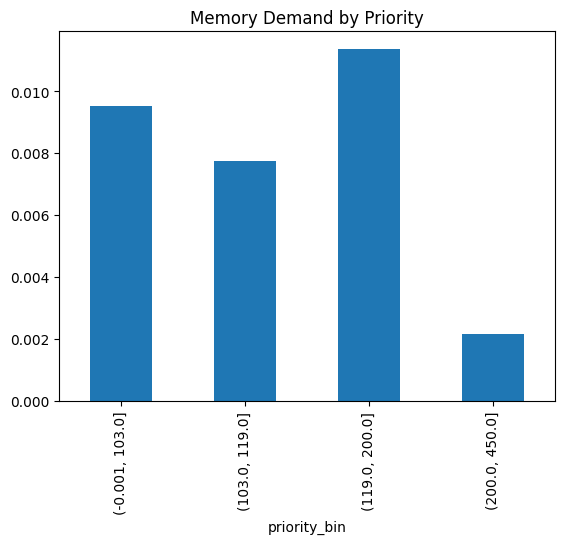

In [ ]:
df_task.groupby('priority_bin')['req_mem'].mean().plot(kind='bar')
plt.title("Memory Demand by Priority")
plt.show()

/tmp/ipython-input-1821249737.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_task.groupby('priority_bin')['req_cpu'].mean().plot(kind='bar')


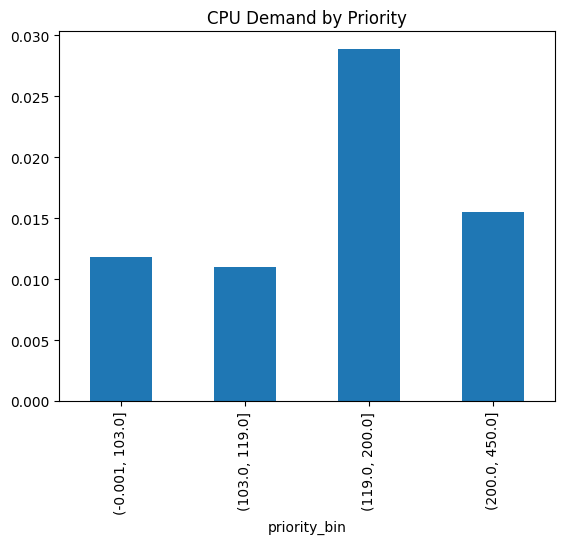

In [ ]:
df_task.groupby('priority_bin')['req_cpu'].mean().plot(kind='bar')
plt.title("CPU Demand by Priority")
plt.show()

/tmp/ipython-input-568451529.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_task.groupby('priority_bin')['duration'].mean().plot(kind='bar')


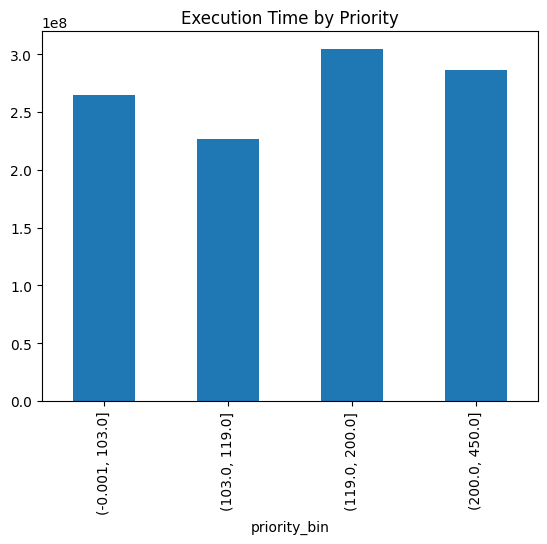

In [ ]:
df_task.groupby('priority_bin')['duration'].mean().plot(kind='bar')
plt.title("Execution Time by Priority")
plt.show()

In [ ]:
df_task['priority_complexity'] = df_task['priority'] * df_task['log_duration']
X = sm.add_constant(df_task[['priority', 'log_duration', 'priority_complexity']])
y = df_task['failed']

model3 = sm.Logit(y, X).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.555993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 failed   No. Observations:                 2001
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            3
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                 0.01582
Time:                        15:07:17   Log-Likelihood:                -1112.5
converged:                       True   LL-Null:                       -1130.4
Covariance Type:            nonrobust   LLR p-value:                 8.431e-08
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.6220      1.419     -2.552      0.011      -6.403      -0.841
pr

<Axes: xlabel='log_duration', ylabel='failed'>

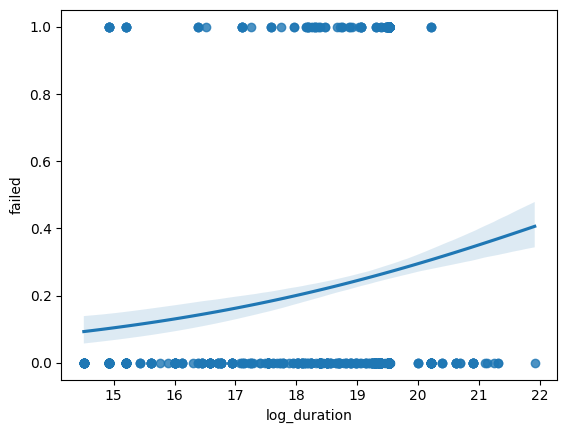

In [ ]:
sns.regplot(x='log_duration', y='failed', data=df_task, logistic=True)

In [ ]:
#### RQ1

In [ ]:
import pandas as pd
import numpy as np
import ast

df = pd.read_csv("borg_traces_data.csv")


In [ ]:
def parse_dict(x):
    try:
        return ast.literal_eval(x)
    except:
        return {}

df['resource_request'] = df['resource_request'].apply(parse_dict)
df['average_usage'] = df['average_usage'].apply(parse_dict)



In [ ]:
df['req_cpu'] = df['resource_request'].apply(lambda x: x.get('cpus', 0))
df['req_mem'] = df['resource_request'].apply(lambda x: x.get('memory', 0))

df['cpu_usage'] = df['average_usage'].apply(lambda x: x.get('cpus', 0))
df['mem_usage'] = df['average_usage'].apply(lambda x: x.get('memory', 0))


In [ ]:
df['duration'] = df['end_time'] - df['start_time']


In [ ]:
print(df[['req_cpu', 'req_mem', 'cpu_usage', 'mem_usage']].head())


    req_cpu   req_mem  cpu_usage     mem_usage
0  0.020660  0.014435   0.004662  5.920410e-03
1  0.007240  0.001303   0.000000  9.536743e-07
2  0.048584  0.004166   0.024200  2.788544e-03
3  0.070435  0.041626   0.047607  3.442383e-02
4  0.002449  0.000232   0.000271  7.629395e-05


In [ ]:
df_task = df.groupby(['collection_id', 'instance_index']).agg({
    'failed': 'max',
    'priority': 'max',
    'req_cpu': 'max',
    'req_mem': 'max',
    'cpu_usage': 'mean',
    'mem_usage': 'mean',
    'duration': 'sum'
}).reset_index()


In [ ]:
df_task = df_task.replace([np.inf, -np.inf], np.nan)
df_task = df_task.dropna()

df_task = df_task[df_task['duration'] > 0]
df_task = df_task[df_task['req_mem'] > 0]
df_task = df_task[df_task['cpu_usage'] > 0]


In [ ]:
df_task['cost'] = 5 * df_task['req_mem']
df_task['log_cost'] = np.log(df_task['cost'] + 1)

df_task['log_cpu_usage'] = np.log(df_task['cpu_usage'] + 1)
df_task['log_duration'] = np.log(df_task['duration'] + 1)

df_task['efficiency'] = df_task['cpu_usage'] / (df_task['req_mem'] + 1e-6)
df_task['log_efficiency'] = np.log(df_task['efficiency'] + 1)


In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'time', 'instance_events_type', 'collection_id',
       'scheduling_class', 'collection_type', 'priority',
       'alloc_collection_id', 'instance_index', 'machine_id',
       'resource_request', 'constraint', 'collections_events_type', 'user',
       'collection_name', 'collection_logical_name',
       'start_after_collection_ids', 'vertical_scaling', 'scheduler',
       'start_time', 'end_time', 'average_usage', 'maximum_usage',
       'random_sample_usage', 'assigned_memory', 'page_cache_memory',
       'cycles_per_instruction', 'memory_accesses_per_instruction',
       'sample_rate', 'cpu_usage_distribution', 'tail_cpu_usage_distribution',
       'cluster', 'event', 'failed', 'duration', 'req_cpu', 'req_mem',
       'cpu_usage', 'mem_usage'],
      dtype='object')


In [ ]:
df.head(2)


,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,...,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed,duration,req_cpu,req_mem,cpu_usage,mem_usage
0,0,0,2,94591244395,3,1,200,0,144,168846390496,...,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1,300000000,0.02066,0.014435,0.004662,5.920410e-03
1,1,2517305308183,2,260697606809,2,0,360,221495397286,335,85515092,...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1,1000000,0.00724,0.001303,0.000000,9.536743e-07


In [ ]:
df_task = df_task.replace([np.inf, -np.inf], np.nan)
df_task = df_task.dropna()

df_task = df_task[df_task['duration'] > 0]
df_task = df_task[df_task['req_mem'] > 0]
df_task = df_task[df_task['cpu_usage'] > 0]


In [ ]:
df_task['cost'] = 5 * df_task['req_mem']
df_task['log_cost'] = np.log(df_task['cost'] + 1)


In [ ]:
df_task['log_cpu_usage'] = np.log(df_task['cpu_usage'] + 1)


In [ ]:
df_task['log_duration'] = np.log(df_task['duration'] + 1)


In [ ]:
df_task['efficiency'] = df_task['cpu_usage'] / (df_task['req_mem'] + 1e-6)
df_task['log_efficiency'] = np.log(df_task['efficiency'] + 1)


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(df_task[['log_cost']])
y = df_task['log_cpu_usage']

model1 = sm.OLS(y, X).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:          log_cpu_usage   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                 2.166e+04
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:43:49   Log-Likelihood:             5.8627e+05
No. Observations:              228539   AIC:                        -1.173e+06
Df Residuals:                  228537   BIC:                        -1.173e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065   4.35e-05    148.325      0.0

In [ ]:
X = sm.add_constant(df_task[['log_cost']])
y = df_task['log_duration']

model2 = sm.OLS(y, X).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1608.
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:43:55   Log-Likelihood:            -4.3861e+05
No. Observations:              228539   AIC:                         8.772e+05
Df Residuals:                  228537   BIC:                         8.772e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.0147      0.004   4929.826      0.0

In [ ]:
X = sm.add_constant(df_task[['log_cost']])
y = df_task['log_efficiency']

model3 = sm.OLS(y, X).fit()
print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:         log_efficiency   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                 1.170e+04
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:44:01   Log-Likelihood:            -2.9138e+05
No. Observations:              228539   AIC:                         5.828e+05
Df Residuals:                  228537   BIC:                         5.828e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8965      0.002    442.681      0.0

In [ ]:
X = sm.add_constant(df_task[['log_cost', 'priority']])
y = df_task['log_cpu_usage']

model4 = sm.OLS(y, X).fit()
print(model4.summary())


                            OLS Regression Results                            
Dep. Variable:          log_cpu_usage   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 1.793e+04
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:44:05   Log-Likelihood:             5.9258e+05
No. Observations:              228539   AIC:                        -1.185e+06
Df Residuals:                  228536   BIC:                        -1.185e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.639e-05   7.04e-05      0.802      0.4

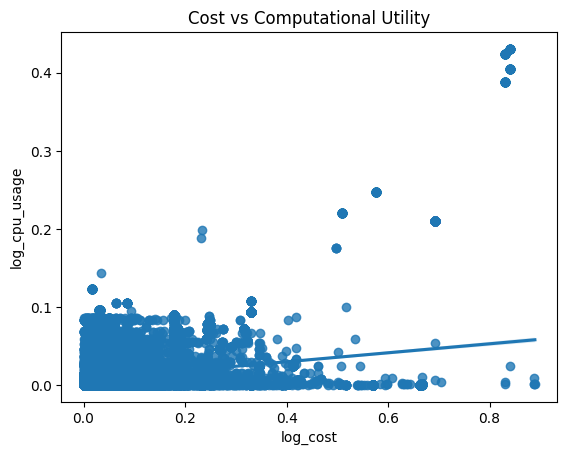

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x='log_cost', y='log_cpu_usage', data=df_task)
plt.title("Cost vs Computational Utility")
plt.show()


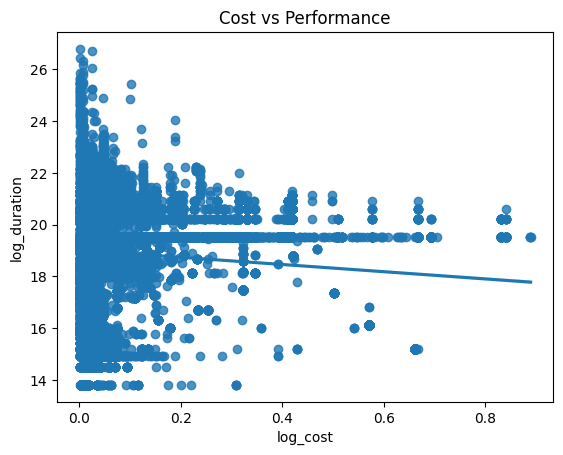

In [ ]:
sns.regplot(x='log_cost', y='log_duration', data=df_task)
plt.title("Cost vs Performance")
plt.show()


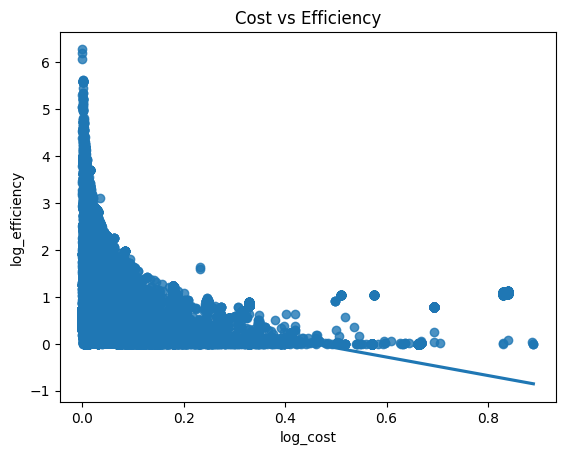

In [ ]:
sns.regplot(x='log_cost', y='log_efficiency', data=df_task)
plt.title("Cost vs Efficiency")
plt.show()


/tmp/ipython-input-3225536273.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_task.groupby('cost_bin')['efficiency'].mean().plot(kind='bar')


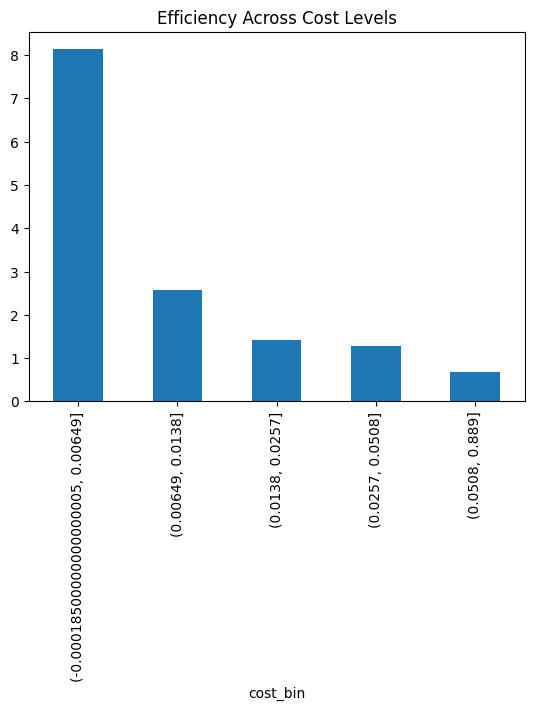

In [ ]:
df_task['cost_bin'] = pd.qcut(df_task['log_cost'], 5)

df_task.groupby('cost_bin')['efficiency'].mean().plot(kind='bar')
plt.title("Efficiency Across Cost Levels")
plt.show()
